* **Práctica 1: Introducción a la segmentación semántica: preprocesado, métricas e inferencia.**
* **Práctica 2: Implementación y entrenamiento de redes UNET para un problema binario (dataset carvana)**
* **Práctica 3: Implementación y entrenamiento de redes FCN para un problema multiclase (dataset cityscapes)**

In [ ]:
# Montar el directorio que contiene los datos (IMPORTANTE: antes añadir la carpeta compartida a nuestro Drive!!)
# Comentar este bloque si la ejecución es en local
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_path = "/content/drive/MyDrive/Segmentation/Practica 2"

In [1]:
# Importacion de librerias
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import tensorflow as tf
from PIL import Image
import os
import numpy as np
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import tqdm
from time import time

In [ ]:
os.listdir(main_path)

['scripts',
 'models',
 'images',
 'CarvanaDataset',
 'generateTestSet.ipynb',
 'UNETcarvana.ipynb',
 'Copia de UNETcarvanaSOLS.ipynb']

# **Segmentación semántica en PyTorch: Caso práctico**

## **Máster IA3: Aprendizaje Profundo II**

### *Antonio Martínez González (antonio.martinez-gonzalez@uv.es)*

En este documento desarrollaremos desde cero todas las etapas necesarias para entrenar una red uNET con el propósito de resolver un problema de segmentación semántica binaria sobre el dataset Carvana (Kaggle, 2017).

Brian Shaler, DanGill, Maggie, Mark McDonald, Patricia, Will Cukierski. (2017). Carvana Image Masking Challenge. Kaggle. https://kaggle.com/competitions/carvana-image-masking-challenge



# **Introducción**

El objetivo de la competición consiste en desarrollar un modelo que permita automatizar de forma precisa la segmentación de imágenes de vehículos a partir de un banco de imágenes proporcionado por la startup Carvana.

![picture](https://storage.googleapis.com/kaggle-media/competitions/kaggle/3333/media/carvana_graphics.png)

Para ello se adquieren 16 imágenes de cada vehículo sobre una plataforma rotatoria en diferentes ángulos, las cuales son segmentadas manualmente resultando en una máscara binaria como target.

* Input: imagen RGB
* Output: imagen GrayScale

En todo momento se presupone una cuantización de 8 bits (uint8).

# **Importación y preprocesado**

El primer paso en cualquier problema de modelización consiste en analizar y comprender la estructura de las entradas y salidas, comenzando por el formato en el que son proporcionadas.

Los datos se encuentran en el directorio local *dataset*. Dentro se dispone de tres subdirecotrios: *train*, *val* y *test*. Dentro de cada subdirectorio se encuentran las imágenes (inputs) y máscaras (outputs), separadas en dos nuevos subdirectorios.

In [ ]:
os.listdir(os.path.join(main_path, "CarvanaDataset"))

['train', 'val', 'test', 'pruebas']

In [ ]:
os.listdir(os.path.join(main_path, "CarvanaDataset", "pruebas"))

['images', 'masks', 'unetv0-predictions-new']

Una vez tenemos clara la localización de los datos, veamos el formato en el que son proporcionados. Para ello listamos las 10 primeras imágenes y máscaras primeros del conjunto de validación, ordenadas alfabéticamente según su ruta local:

In [ ]:
sorted(os.listdir(os.path.join(main_path, "CarvanaDataset", "pruebas", "images")))[:10]

['0d3adbbc9a8b_04.jpg',
 '151c7f2d4183_04.jpg',
 '2990f858e939_10.jpg',
 '2c57132da7a0_13.jpg',
 '2ea62c1beee7_10.jpg',
 '34b0c08544a5_06.jpg',
 '36a3f7f77e85_02.jpg',
 '424658d9f222_13.jpg',
 '4a4364d7fc6d_11.jpg',
 '51f1cdf5f539_12.jpg']

In [ ]:
sorted(os.listdir(os.path.join(main_path, "CarvanaDataset", "pruebas", "masks")))[:10]

['0d3adbbc9a8b_04_mask.gif',
 '151c7f2d4183_04_mask.gif',
 '2990f858e939_10_mask.gif',
 '2c57132da7a0_13_mask.gif',
 '2ea62c1beee7_10_mask.gif',
 '34b0c08544a5_06_mask.gif',
 '36a3f7f77e85_02_mask.gif',
 '424658d9f222_13_mask.gif',
 '4a4364d7fc6d_11_mask.gif',
 '51f1cdf5f539_12_mask.gif']

Como podemos observar la ruta de cada imágen esta formada por un código, computesto por el identificador del vehículo junto con el índice asociado a cada una de las 16 capturas, ambos separados mediante el carácter _.

Por ejemplo 00087a6bd4dc_04.jpg es la imágen asociada a la cuarta captura del vehículo *00087a6bd4dc*. La extensión es JPG.

Por otro lado, la ruta de cada máscara consiste en añadir el sufijo _mask a la ruta de la imágen y sustituir la extensión JPG por GIF.

In [ ]:
def get_image_metadata(image_path):
    # Open the image file
    with Image.open(image_path) as img:
        # Extracting basic information
        metadata = {
            "format": img.format,
            "mode": img.mode,
            "size": img.size,
        }
    return metadata

In [ ]:
get_image_metadata(os.path.join(main_path, "CarvanaDataset", "pruebas", "images", "0d3adbbc9a8b_04.jpg"))

{'format': 'JPEG', 'mode': 'RGB', 'size': (1918, 1280)}

In [ ]:
get_image_metadata(os.path.join(main_path, "CarvanaDataset", "pruebas", "masks", "0d3adbbc9a8b_04_mask.gif"))

{'format': 'GIF', 'mode': 'P', 'size': (1918, 1280)}

Una vez tenemos localizados los datos y el formato en el que se presentan procedemos con el preprocesado.

En un problema de estas características el pipeline habitual es el siguiente:

*ruta de la imágen* -> *conversión a objeto PIL* -> *conversión a np.array* -> *preprocesado* -> *conversión a tensor*

Donde el preprocesado se suele realizar mediante librerías especializadas como albumentations.

In [ ]:
def loadImageAndMask(image_dir, mask_dir, code):
    """importación de una muestra del dataset Carvana"""
    codes = [i.replace(".jpg", "") for i in os.listdir(image_dir)]
    if code not in codes:
        raise ValueError(f"Can't find the image with code {code} inside the directory {image_dir}")
    image = Image.open(os.path.join(image_dir, code+".jpg")).convert("RGB")
    mask = Image.open(os.path.join(mask_dir, code+"_mask.gif")).convert("L")
    return image, mask

In [ ]:
image, mask = loadImageAndMask(os.path.join(main_path, "CarvanaDataset", "pruebas", "images"), os.path.join(main_path, "CarvanaDataset", "pruebas", "masks"), code='0d3adbbc9a8b_04')

In [ ]:
type(image)

PIL.Image.Image

In [ ]:
new_width = 600
aspect_ratio = image.width / image.height
new_height = int(new_width / aspect_ratio)

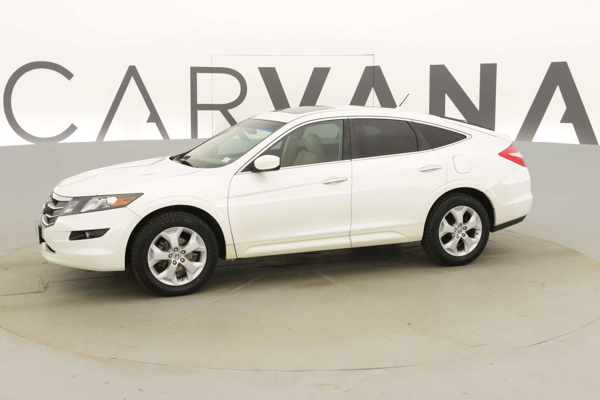

In [ ]:
image.resize((new_width, new_height))

In [ ]:
type(mask)

PIL.Image.Image

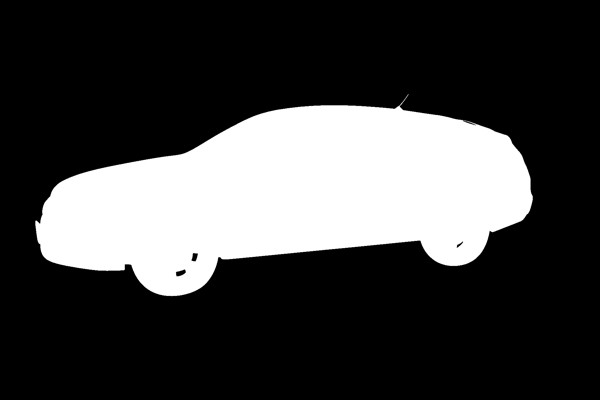

In [ ]:
mask.resize((new_width, new_height))

Una vez sabemos como realizar las etapas de importación y preprocesado para una instancia del dataset, el próximo paso consiste en generalizar la implementación para un conjunto arbitrario de muestras con estructura similar.

Siguiendo la documentación oficial de PyTorch, lo recomendado es definir una clase que proporcione las muestras al modelo según sean requeridas (tanto para entrenamiento como para inferencia):

* Hereda de la clase torch.utils.data.Dataset
* Recibe como entrada la fuente primaria de los datos (los directorios que contienen las imágenes y máscaras en este caso), ademaś de varios parámetros de control
* Implemente las etapas de importación y preprocesado mediante métodos específicos. Cada llamada al método en cuestión debe proporcionar como salida una muestra (el par compuesto por la imágen y la máscara) sin necesidad de almacenar todo el conjunto de datos en memoria.

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
class carvanaDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, scale=False, to_torch_tensor=False):
        self.image_dir = image_dir # Ruta del directorio que contiene las imagenes de entrada
        self.mask_dir = mask_dir # Ruta del directorio que contiene las mascaras de salida
        self.codes = [i.replace(".jpg", "") for i in os.listdir(image_dir)] # Lista que contiene los codigos identificadores de cada imagen
        self.transform = transform
        self.scale = scale
        self.to_torch_tensor = to_torch_tensor

    def __len__(self): # Devuelve el numero de muestras del dataset (una por cada codigo identificador de la imagen)
        return len(self.codes)

    def __getitem__(self, index): # Importación y preprocesado de una muestra
        code = self.codes[index]
        img_path = os.path.join(self.image_dir, code+".jpg") # Ruta de la imagen de entrada
        mask_path = os.path.join(self.mask_dir, code+"_mask.gif") # Ruta de la mascara
        image = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32)
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0
        if self.scale:
            image = image / 255.0
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        else:
            image = np.transpose(image, (2,0,1))
            self.to_torch_tensor = True
        if self.to_torch_tensor:
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)
        return image, mask

Comprobamos que funciona correctamente:

In [ ]:
val_dataset = carvanaDataset(
    image_dir=os.path.join(main_path, "CarvanaDataset", "pruebas", "images"),
    mask_dir=os.path.join(main_path, "CarvanaDataset", "pruebas", "masks"),
    transform=A.Compose([
        ToTensorV2()
    ]),
    scale=True,
)
img0, mask0 = val_dataset[0]

In [ ]:
img0.shape

torch.Size([3, 1280, 1918])

In [ ]:
img0

tensor([[[0.9843, 0.9843, 0.9843,  ..., 0.9686, 0.9686, 0.9686],
         [0.9843, 0.9843, 0.9843,  ..., 0.9686, 0.9686, 0.9686],
         [0.9843, 0.9843, 0.9843,  ..., 0.9686, 0.9686, 0.9686],
         ...,
         [0.8510, 0.8510, 0.8510,  ..., 0.8392, 0.8392, 0.8392],
         [0.8510, 0.8510, 0.8510,  ..., 0.8392, 0.8392, 0.8392],
         [0.8510, 0.8510, 0.8510,  ..., 0.8392, 0.8392, 0.8392]],

        [[0.9843, 0.9843, 0.9843,  ..., 0.9686, 0.9686, 0.9686],
         [0.9843, 0.9843, 0.9843,  ..., 0.9686, 0.9686, 0.9686],
         [0.9843, 0.9843, 0.9843,  ..., 0.9686, 0.9686, 0.9686],
         ...,
         [0.8510, 0.8510, 0.8510,  ..., 0.8549, 0.8549, 0.8549],
         [0.8510, 0.8510, 0.8510,  ..., 0.8549, 0.8549, 0.8549],
         [0.8510, 0.8510, 0.8510,  ..., 0.8549, 0.8549, 0.8549]],

        [[0.9843, 0.9843, 0.9843,  ..., 0.9686, 0.9686, 0.9686],
         [0.9843, 0.9843, 0.9843,  ..., 0.9686, 0.9686, 0.9686],
         [0.9843, 0.9843, 0.9843,  ..., 0.9686, 0.9686, 0.

In [ ]:
mask0.shape

torch.Size([1280, 1918])

In [ ]:
mask0

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
np.unique(mask0)

array([0., 1.], dtype=float32)

Pasando la instancia de la clase *carvanaDataset* como principal argumento al constructor de la clase *DataLoader* obtenemos un nuevo objeto que dispone de la funcionalidad necesaria para organizar las muestras en mini-batches, además de otros factores importantes:

* Parámetro shuffle: permite especificar si permutar el órden de las muestras entre épocas
* Parámetro num_workers: número de threads asignadas a la ejecución de los métodos del parámetro principal
* Parámetro pin_memory: permite acelerar la transferencia de datos entre el host (cpu) y el device (cpu/gpu).
* etc

https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [ ]:
val_dataloader = torch.utils.data.DataLoader(
    carvanaDataset(
    image_dir=os.path.join(main_path, "CarvanaDataset", "pruebas", "images"),
    mask_dir=os.path.join(main_path, "CarvanaDataset", "pruebas", "masks"),
    transform=A.Compose([
        A.Resize(height=160, width=240),
        ToTensorV2()
        ]),
    scale=True,
    ),
    batch_size=4,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

In [ ]:
inbatch0, outbatch0 = next(iter(val_dataloader))

In [ ]:
inbatch0.shape

torch.Size([4, 3, 160, 240])

In [ ]:
outbatch0.shape

torch.Size([4, 160, 240])

**Ejercicio**: Calcular la media y desviación típica de cada canal de las imágenes del conjunto de validación. Utilizar la clase val_dataloader para acceder a las imágenes.

Pista:

* Iterar sobre val_dataloader
    * Acumular la suma de los pixeles para cada canal
    * Acumular la suma de los cuadrados de los pixeles para cada canal
    * calcular la desviación típica según la expresión:
$s=\sqrt{\frac{\sum x_i^2}{n}-\bar{x}}$
* Tener en cuenta que en cada iteración el dataloader proporciona un batch de imágenes!


In [ ]:
def compute_mean_std(dataloader):

    #####################
    ## escribir codigo ##
    mean = None
    std = None
    #####################

    return mean, std

In [ ]:
def compute_mean_std(dataloader, height=160, width=240):

    # Inicializar variables
    sums = torch.tensor([0.0, 0.0, 0.0])
    sums_sq = torch.tensor([0.0, 0.0, 0.0])
    # Calcular numero de muestras para normalizar mean y std
    n_samples = dataloader.batch_size * len(dataloader) * height * width

    # Iterar sobre el dataset (asume que cada iteracion proporciona un batch de x muestras)
    for inputs, _ in dataloader:

        # Asume inputs con shape [batch_size, channels, height, width]
        sums += inputs.sum([0, 2, 3])  # Sum over batch, height, and width dimensions
        sums_sq += (inputs ** 2).sum([0, 2, 3])  # Sum of squares

    # Normalizar tensor de medias por el número de muestras
    mean = sums / n_samples
    # Calcular tensor de std y normalizar por número de muestras
    std = torch.sqrt(sums_sq/n_samples - mean**2)
    return mean, std

In [ ]:
mean, std = compute_mean_std(val_dataloader)
print("per channel mean of validation set", mean)
print("per channel std of validation set", std)

per channel mean of validation set tensor([0.6355, 0.6267, 0.6186])
per channel std of validation set tensor([0.3138, 0.3162, 0.3114])


El ejercicio anterior es muy util, pues a partir de la media y desviación típica de cada uno de los canales del conjunto de entrenamiento podemos definir una transformación de estandarización de los datos (se aplicarían los valores obtenidos sobre el conjunto de entrenamiento a los conjuntos de validación y test).

**Ejercicio**: Definir una clase en Tensorflow que implemente la misma funcionalidad que la clase DataLoader para el problema actual.

Pista: aprovechar el código de la clase carvanaDataset con ciertas modificaciones:

* Heredar de tf.keras.utils.Sequence (leer su documentación)
* Implementar la organización en mini batches en el método \__getitem__
* Implementar la permutación del órden de las muestras mediante un método adicional de nombre _on_epoch_end

In [ ]:
class carvanaDatasetTF(tf.keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir, transform=None, scale=False, batch_size=4, shuffle=True, to_tf_tensor=False,):
        self.image_dir = image_dir # Ruta del directorio que contiene las imagenes de entrada
        self.mask_dir = mask_dir # Ruta del directorio que contiene las mascaras de salida
        self.codes = [i.replace(".jpg", "") for i in os.listdir(image_dir)] # Lista que contiene los codigos de cada imagen
        self.transform = transform
        self.scale = scale
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.to_tf_tensor = to_tf_tensor

    def __len__(self): # Devuelve el numero de batches
        return len(self.codes) // self.batch_size

    def __getitem__(self, index): # Importación y preprocesado de un mini-batch
        inbatch = []
        outbatch = []

        #####################
        ## escribir codigo ##
        #####################

        if self.to_tf_tensor:
            inbatch, outbatch = tf.convert_to_tensor(inbatch), tf.convert_to_tensor(outbatch)
        return inbatch, outbatch

    def on_epoch_end(self):

        #####################
        ## escribir codigo ##
        #####################

        return None

In [ ]:
class carvanaDatasetTF(tf.keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir, transform=None, scale=False, batch_size=4, shuffle=True, to_tf_tensor=False,):
        self.image_dir = image_dir # Ruta del directorio que contiene las imagenes de entrada
        self.mask_dir = mask_dir # Ruta del directorio que contiene las mascaras de salida
        self.codes = [i.replace(".jpg", "") for i in os.listdir(image_dir)] # Lista que contiene los codigos de cada imagen
        self.transform = transform
        self.scale = scale
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.to_tf_tensor = to_tf_tensor

    def __len__(self): # Devuelve el numero de batches
        return len(self.codes) // self.batch_size

    def __getitem__(self, index): # Importación y preprocesado de un batcch
        inbatch = []
        outbatch = []
        codes = self.codes[index*self.batch_size:(index+1)*self.batch_size]
        for code in codes:
            img_path = os.path.join(self.image_dir, code+".jpg") # Ruta de la imagen de entrada
            mask_path = os.path.join(self.mask_dir, code+"_mask.gif") # Ruta de la mascara
            image = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32)
            mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
            mask[mask == 255.0] = 1.0
            if self.scale:
                image = image / 255.0
            if self.transform:
                transformed = self.transform(image=image, mask=mask)
                image = transformed["image"]
                mask = transformed["mask"]
            inbatch.append(image)
            outbatch.append(mask)
        inbatch, outbatch = np.array(inbatch), np.array(outbatch)
        if self.to_tf_tensor:
            inbatch, outbatch = tf.convert_to_tensor(inbatch), tf.convert_to_tensor(outbatch)
        return inbatch, outbatch

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.codes)

In [ ]:
val_dataloaderTF = carvanaDatasetTF(
    image_dir=os.path.join(main_path, "CarvanaDataset", "pruebas", "images"),
    mask_dir=os.path.join(main_path, "CarvanaDataset", "pruebas", "masks"),
    batch_size=4,
    scale=True,
    shuffle=False,
    to_tf_tensor=True
)

In [ ]:
inbatch0, outbatch0 = val_dataloaderTF[0]

In [ ]:
inbatch0.shape

TensorShape([4, 1280, 1918, 3])

In [ ]:
inbatch0[0]

<tf.Tensor: shape=(1280, 1918, 3), dtype=float32, numpy=
array([[[0.9843137 , 0.9843137 , 0.9843137 ],
        [0.9843137 , 0.9843137 , 0.9843137 ],
        [0.9843137 , 0.9843137 , 0.9843137 ],
        ...,
        [0.96862745, 0.96862745, 0.96862745],
        [0.96862745, 0.96862745, 0.96862745],
        [0.96862745, 0.96862745, 0.96862745]],

       [[0.9843137 , 0.9843137 , 0.9843137 ],
        [0.9843137 , 0.9843137 , 0.9843137 ],
        [0.9843137 , 0.9843137 , 0.9843137 ],
        ...,
        [0.96862745, 0.96862745, 0.96862745],
        [0.96862745, 0.96862745, 0.96862745],
        [0.96862745, 0.96862745, 0.96862745]],

       [[0.9843137 , 0.9843137 , 0.9843137 ],
        [0.9843137 , 0.9843137 , 0.9843137 ],
        [0.9843137 , 0.9843137 , 0.9843137 ],
        ...,
        [0.96862745, 0.96862745, 0.96862745],
        [0.96862745, 0.96862745, 0.96862745],
        [0.96862745, 0.96862745, 0.96862745]],

       ...,

       [[0.8509804 , 0.8509804 , 0.8509804 ],
        [0.

In [ ]:
outbatch0.shape

TensorShape([4, 1280, 1918])

In [ ]:
np.unique(outbatch0[0])

array([0., 1.], dtype=float32)

# **Modelo**

El modelo escogido para este problema consiste en una modificación de la red uNET, propuesta inicialmente para la segmentación de imágenes biomédicas:

*U-Net: Convolutional Networks for Biomedical Image Segmentation* https://arxiv.org/abs/1505.04597

* Arquitectura encoder-decoder con estructura simétrica
* Conexiones de salto (skip connections) y cropping para la concatenación
* Downsampling mediante maxpooling con kernel cuadrado y stride = 2
* Upsampling mediante convoluciones traspuestas 2D con kernel cuadrado y stride = 2

![picture](https://miro.medium.com/v2/resize:fit:1400/1*f7YOaE4TWubwaFF7Z1fzNw.png)

Veamos como definir paso a paso el modelo uNET a partir de la imágen anterior. Se ha optado por realizar los siguientes cambios sobre la arquitectura original:

* Zero padding en las capas convolucionales para evitar perder resolución espacial (de esta forma la salida tendrá la misma dimensión que la entrada, salvo ciertas consideraciones)
* Batch normalization entre la salida de cada capa convolucional y la función de activación posterior (dota de una mayor estabilidad al proceso de aprendizaje)
* Posibilidad de elegir entre las dos siguientes opciones para la operación de concatenación:
    * *Recortar* las skips connections (crop) -> la salida predicha pierde resolución espacial respecto de la entrada si la altura o anchura de la entrada no es divisible por 2**4 (debido a la aplicación de 4 capas maxpooling en el encoder, cada una de ellas cambia la anchura o altura de su entrada de x a x // 2)
    * Aplicar zero padding a la salida de la capa up-sampler (conv2dtranspose) -> las dimensiones de entrada y salida predicha coinciden

**Nota**: aplicar una operación de convolución o pooling con un kernel de tamaño $(k_x,k_y)$, padding=p y strides=s sobre un tensor de tamaño (N,C,H,W) produce un nuevo tensor de tamaño (N,C,H',W') donde:

* $H' = floor(\frac{H-k_x+2p}{s}+1)$
* $W' = floor(\frac{W-k_y+2p}{s}+1)$

*floor(x) es la función parte entera por debajo*


In [ ]:
class stack2convs(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=True):
      super(stack2convs, self).__init__()
      self.batch_norm = batch_norm
      self.conv2d_a = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=~self.batch_norm)
      self.conv2d_b = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=~self.batch_norm)
      if self.batch_norm:
          self.batchnorm_a = nn.BatchNorm2d(num_features=out_channels)
          self.batchnorm_b = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, x):
      x = self.conv2d_a(x)
      if self.batch_norm:
          x = self.batchnorm_a(x)
      x = F.relu(x)
      x = self.conv2d_b(x)
      if self.batch_norm:
          x = self.batchnorm_b(x)
      x = F.relu(x)
      return x

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, feats_per_block=[64, 128, 256, 512], batch_norm=True):
        super(UNET, self).__init__()

        self.n_blocks = len(feats_per_block)
        self.contraction_path = nn.ModuleList()
        self.expansion_path_convs = nn.ModuleList()
        self.expansion_path_upsamplers = nn.ModuleList()

        # Build contraction path trainable layers
        for feats in feats_per_block:
            self.contraction_path.append(stack2convs(in_channels=in_channels, out_channels=feats, batch_norm=batch_norm))
            in_channels = feats

        # Build expansion path trainable layers
        for feats in feats_per_block[::-1]:
            self.expansion_path_convs.append(stack2convs(in_channels=feats*2, out_channels=feats, batch_norm=batch_norm))
            self.expansion_path_upsamplers.append(nn.ConvTranspose2d(in_channels=feats*2, out_channels=feats, kernel_size=2, stride=2))

        # Stack of 2D convs as bottleneck
        self.bottleneck = stack2convs(feats_per_block[-1], feats_per_block[-1]*2, batch_norm=batch_norm)
        # Point-wise 2D convolution as final model layer
        self.pointwise_conv = nn.Conv2d(feats_per_block[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Build an empty list to store the skip connections
        skips = []
        # Contraction path (encoder)
        for block in self.contraction_path:
            x = block(x)
            skips.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
        # Bottleneck
        x = self.bottleneck(x)
        # Expansion path (decoder)
        for i in range(self.n_blocks):
            x = self.expansion_path_upsamplers[i](x)
            skip = skips[-(i+1)]
            valid_height = x.size(2)
            valid_width = x.size(3)
            height_diff = skip.size(2) - valid_height
            width_diff = skip.size(3) - valid_width
            if height_diff or width_diff:
                to_concat = skip[:,:,height_diff//2:height_diff//2+valid_height,width_diff//2:width_diff//2+valid_width]
                x = torch.cat((to_concat, x), dim=1)
            else:
                x = torch.cat((skip, x), dim=1)
            x = self.expansion_path_convs[i](x)
        # Final layer
        x = self.pointwise_conv(x)
        return x

Comprobamos que no hay errores y que el funcionamiento es el esperado en lo que respecta al tamaño de la salida.

In [ ]:
x = torch.randn((3, 3, 161, 240)) # 161 no es divisble por 2**4=16
model = UNET(in_channels=3, out_channels=1)
preds = model(x)
print(preds.shape)

torch.Size([3, 1, 160, 240])


El funcionamiento es correcto.

Notar como al trabajar con una altura o anchura que no es divsible por $2^4=16$ perdemos la resolución espacial de la entrada. Aunque la pérdida sea pequeña es crucial gestionarla de forma adecuada ya que la operación de concatenación requiere que los tensores de entrada tengan los mismos tamaños (salvo en las dimensiones sobre las que se concatena).

Esto se puede solucionar de muchas formas:
* Aplicando padding a la entrada y salida de modo que la altura y anchura cumpla las características deseadas.
* Aplicando upsampling sobre la salida de la capa conv2dtranspose para que el tamaño coincida con el de la skip connection (por ejemplo interpolación bilineal)

**Ejercicio**: Modificar la clase UNET de modo que cuando exista pérdida de resolución espacial se pueda escoger entre aplicar cropping sobre la skip connection (ya implementado) o upsampling mediante zero-padding sobre la salida de la capa conv2dtranspose.

* Pista: añadir un parámetro de control en el método init de la clase UNET y modificar el bucle del expansion path (forward pass) de la siguiente forma: si parámetro es True aplicar cropping, si parámetro es False aplicar la función torch.nn.functional.pad sobre la salida de la capa conv2dtranspose

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, feats_per_block=[64, 128, 256, 512], batch_norm=True, crop=True, logits=True):
        super(UNET, self).__init__()

        self.n_blocks = len(feats_per_block)
        self.crop = crop
        self.logits = logits
        self.contraction_path = nn.ModuleList()
        self.expansion_path_convs = nn.ModuleList()
        self.expansion_path_upsamplers = nn.ModuleList()

        # Build contraction path trainable layers
        for feats in feats_per_block:
            self.contraction_path.append(stack2convs(in_channels=in_channels, out_channels=feats, batch_norm=batch_norm))
            in_channels = feats

        # Build expansion path trainable layers
        for feats in feats_per_block[::-1]:
            self.expansion_path_convs.append(stack2convs(in_channels=feats*2, out_channels=feats, batch_norm=batch_norm))
            self.expansion_path_upsamplers.append(nn.ConvTranspose2d(in_channels=feats*2, out_channels=feats, kernel_size=2, stride=2))

        # Stack of 2D convs as bottleneck
        self.bottleneck = stack2convs(feats_per_block[-1], feats_per_block[-1]*2, batch_norm=batch_norm)
        # Point-wise 2D convolution as final model layer
        self.pointwise_conv = nn.Conv2d(feats_per_block[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Build an empty list to store the skip connections
        skips = []
        # Contraction path (encoder)
        for block in self.contraction_path:
            x = block(x)
            skips.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
        # Bottleneck
        x = self.bottleneck(x)
        # Expansion path (decoder)
        for i in range(self.n_blocks):
            x = self.expansion_path_upsamplers[i](x)
            skip = skips[-(i+1)]
            valid_height = x.size(2)
            valid_width = x.size(3)
            height_diff = skip.size(2) - valid_height
            width_diff = skip.size(3) - valid_width
            if height_diff or width_diff:
                if self.crop:
                    to_concat = skip[:,:,height_diff//2:height_diff//2+valid_height,width_diff//2:width_diff//2+valid_width]
                    x = torch.cat((to_concat, x), dim=1)
                else:
                  #adjust_shapes = "interpolate", "zeropad"
                  #####################
                  ## escribir codigo ##
                  #####################
                  pass
            else:
                x = torch.cat((skip, x), dim=1)
            x = self.expansion_path_convs[i](x)
        # Final layer
        x = self.pointwise_conv(x)
        return x

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, feats_per_block=[64, 128, 256, 512], batch_norm=True, crop=True, logits=True):
      super(UNET, self).__init__()

      self.n_blocks = len(feats_per_block)
      self.crop = crop
      self.logits = logits
      self.contraction_path = nn.ModuleList()
      self.expansion_path_convs = nn.ModuleList()
      self.expansion_path_upsamplers = nn.ModuleList()

      # Build contraction path trainable layers
      for feats in feats_per_block:
          self.contraction_path.append(stack2convs(in_channels=in_channels, out_channels=feats, batch_norm=batch_norm))
          in_channels = feats

      # Build expansion path trainable layers
      for feats in feats_per_block[::-1]:
          self.expansion_path_convs.append(stack2convs(in_channels=feats*2, out_channels=feats, batch_norm=batch_norm))
          self.expansion_path_upsamplers.append(nn.ConvTranspose2d(in_channels=feats*2, out_channels=feats, kernel_size=2, stride=2))

      # Stack of 2D convs as bottleneck
      self.bottleneck = stack2convs(feats_per_block[-1], feats_per_block[-1]*2, batch_norm=batch_norm)
      # Point-wise 2D convolution as final model layer
      self.pointwise_conv = nn.Conv2d(feats_per_block[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Build an empty list to store the skip connections
        skips = []
        # Contraction path (encoder)
        for block in self.contraction_path:
            x = block(x)
            skips.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
        # Bottleneck
        x = self.bottleneck(x)
        # Expansion path (decoder)
        for i in range(self.n_blocks):
          x = self.expansion_path_upsamplers[i](x)
          skip = skips[-(i+1)]
          valid_height = x.size(2)
          valid_width = x.size(3)
          height_diff = skip.size(2) - valid_height
          width_diff = skip.size(3) - valid_width
          if height_diff or width_diff:
              if self.crop:
                  to_concat = skip[:,:,height_diff//2:height_diff//2+valid_height,width_diff//2:width_diff//2+valid_width]
                  x = torch.cat((to_concat, x), dim=1)
              else:
                  pad_left = width_diff // 2
                  pad_right = width_diff - pad_left
                  pad_top = height_diff // 2
                  pad_bottom = height_diff - pad_top
                  to_concat = F.pad(x, pad=(pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)
                  x = torch.cat((skip, to_concat), dim=1)
          else:
              x = torch.cat((skip, x), dim=1)
          x = self.expansion_path_convs[i](x)
        # Final layer
        x = self.pointwise_conv(x)
        if not self.logits:
            x = F.sigmoid(x)
        return x

In [ ]:
x = torch.randn((3, 3, 161, 240)) # 161 no es divisble por 2**4=16
model = UNET(in_channels=3, out_channels=1, crop=False)
preds = model(x)
print(preds.shape) # mantiene la resolución espacial de la entrada cuando la altura/anchura no es divisible por 2**4

torch.Size([3, 1, 161, 240])


### **Bonus: UNET en Tensorflow**

In [ ]:
class Stack2Convs(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, batch_norm=True, input_shape=None):
        super(Stack2Convs, self).__init__()
        self.batch_norm = batch_norm
        if input_shape:
            self.conv2d_a = tf.keras.layers.Conv2D(out_channels, 3, strides=1, padding='same', use_bias=~self.batch_norm, input_shape=input_shape)
        else:
            self.conv2d_a = tf.keras.layers.Conv2D(out_channels, 3, strides=1, padding='same', use_bias=~self.batch_norm)

        self.conv2d_b = tf.keras.layers.Conv2D(out_channels, 3, strides=1, padding='same', use_bias=~self.batch_norm)
        if self.batch_norm:
            self.batchnorm_a = tf.keras.layers.BatchNormalization()
            self.batchnorm_b = tf.keras.layers.BatchNormalization()

    def call(self, x):
        x = self.conv2d_a(x)
        if self.batch_norm:
            x = self.batchnorm_a(x)
        x = tf.nn.relu(x)
        x = self.conv2d_b(x)
        if self.batch_norm:
            x = self.batchnorm_b(x)
        x = tf.nn.relu(x)
        return x

class UNETtf(tf.keras.models.Model):
    def __init__(self, input_shape, in_channels=3, out_channels=1, feats_per_block=[64, 128, 256, 512], batch_norm=True, crop=True, logits=True):
        super(UNETtf, self).__init__()

        self.n_blocks = len(feats_per_block)
        self.crop = crop
        self.logits = logits
        self.contraction_path = []
        self.expansion_path_convs = []
        self.expansion_path_upsamplers = []

        # Build contraction path layers
        for feats in feats_per_block:
            self.contraction_path.append(Stack2Convs(in_channels, feats, batch_norm=batch_norm, input_shape=input_shape))
            in_channels = feats

        # Build expansion path layers
        for feats in feats_per_block[::-1]:
            self.expansion_path_convs.append(Stack2Convs(feats*2, feats, batch_norm=batch_norm))
            self.expansion_path_upsamplers.append(tf.keras.layers.Conv2DTranspose(feats, 2, strides=2))
        # Bottleneck
        self.bottleneck = Stack2Convs(feats_per_block[-1], feats_per_block[-1]*2, batch_norm=batch_norm)
        # Point-wise convolution as final layer
        self.pointwise_conv = tf.keras.layers.Conv2D(out_channels, 1)

    def call(self, x):

        skips = []
        # Contraction path
        for block in self.contraction_path:
            x = block(x)
            skips.append(x)
            x = tf.keras.layers.MaxPooling2D(2, strides=2)(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Expansion path
        for i in range(self.n_blocks):
            x = self.expansion_path_upsamplers[i](x)
            skip = skips[-(i + 1)]

            valid_height = tf.shape(x)[1]
            valid_width = tf.shape(x)[2]
            height_diff = tf.shape(skip)[1] - valid_height
            width_diff = tf.shape(skip)[2] - valid_width

            pad_left = width_diff // 2
            pad_right = width_diff - pad_left
            pad_top = height_diff // 2
            pad_bottom = height_diff - pad_top

            to_concat = skip
            # Convert to boolean for Python conditional
            if tf.logical_or(tf.math.greater(height_diff, 0), tf.math.greater(width_diff, 0)):
                if self.crop:
                    to_concat = skip[:, height_diff//2:height_diff//2 + valid_height, width_diff//2:width_diff//2 + valid_width, :]
                else:
                    x = tf.pad(x,
                               paddings=[[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]],
                               mode='CONSTANT',
                               constant_values=0
                               )

            x = tf.concat([to_concat, x], axis=-1)
            x = self.expansion_path_convs[i](x)

        # Final layer
        x = self.pointwise_conv(x)
        if not self.logits:
            x = tf.nn.sigmoid(x)
        return x

In [ ]:
train_dataloaderTF = carvanaDatasetTF(
    image_dir=os.path.join(main_path, "CarvanaDataset", "train", "images"),
    mask_dir=os.path.join(main_path, "CarvanaDataset", "train", "masks"),
    batch_size=2,
    transform=A.Compose([
        A.Resize(height=160, width=240)
        ]),
    scale=True,
    shuffle=True,
    to_tf_tensor=False
)

val_dataloaderTF = carvanaDatasetTF(
    image_dir=os.path.join(main_path, "CarvanaDataset", "val", "images"),
    mask_dir=os.path.join(main_path, "CarvanaDataset", "val", "masks"),
    batch_size=2,
    transform=A.Compose([
        A.Resize(height=160, width=240)
        ]),
    scale=True,
    shuffle=True,
    to_tf_tensor=False,
)

In [ ]:
x, y = train_dataloaderTF.__getitem__(0)
y.shape

(2, 160, 240)

In [ ]:
model = UNETtf(input_shape=(161, 240, 3), crop=True)

In [ ]:
x = tf.constant(np.zeros((1,161,240,3), dtype=np.float32))
model(x).shape

TensorShape([1, 160, 240, 1])

In [ ]:
model = UNETtf(input_shape=(161, 240, 3), crop=False)

In [ ]:
x = tf.constant(np.zeros((1,161,240,3), dtype=np.float32))
model(x).shape

TensorShape([1, 161, 240, 1])

In [ ]:
model = UNETtf(input_shape=(160, 240, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])

In [ ]:
# sin data augmentation
# antes del calculo de accuracy tensorflow sabe que tiene que aplicar sigmoid (la información se la dice el parametro from_logits=True en la funcion de coste)
#model.fit(train_dataloaderTF, validation_data=val_dataloaderTF, epochs=10) # ejecutar con GPU!!

In [ ]:
#model.save(os.path.join("models", "unet-e10-bs16.keras"))

In [ ]:
model = UNETtf(input_shape=(160, 240, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])

In [ ]:
train_dataloaderTF = carvanaDatasetTF(
    image_dir=os.path.join(main_path, "CarvanaDataset", "train", "images"),
    mask_dir=os.path.join(main_path, "CarvanaDataset", "train", "masks"),
    batch_size=16,
    transform=A.Compose([
        A.Resize(height=160, width=240), # Reducir el tamaño para simplificar la carga computacional
        A.Rotate(limit=35, p=0.7), # Rotacion mediante un número aleatorio en el rango [-35,35] con una probablidad de 0.7
        A.HorizontalFlip(p=0.4), # Volteo horizontal con una probabilidad de 0.4
        A.VerticalFlip(p=0.2), # Volteo vertical con una probabilida de 0.2
        ]),
    scale=True,
    shuffle=True,
    to_tf_tensor=False
)

In [ ]:
# con data augmentation
#model.fit(train_dataloaderTF, validation_data=val_dataloaderTF, epochs=10) # ejecutar con GPU!!

In [ ]:
#model.save(os.path.join("models", "unet-e10-bs16-da.keras"))

# **Entrenamiento**

Una vez disponemos de datos preprocesados y un modelo funcional estamos en condiciones de implementar y ejecutar el entrenamiento de la red uNET para la segmentación del dataset Carvana.

Para ello seguiremos a modo general las indicaciones dadas en la documentación de PyTorch

https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

In [ ]:
# Establece como device el dispositvo más adecuado para ejecutar el entrenamiento en base a la capacidad de nuestro sistema
device = (
    "cuda" # Nvidia CUDA-compatible GPU
    if torch.cuda.is_available()
    else "mps" # MPS-compatible MAC computer
    if torch.backends.mps.is_available()
    else "cpu" # General purpose PC with 64bit CPU
)

In [ ]:
# Ruta donde almacenaremos el modelo en formato pth
model_path = os.path.join("models", "unetv00.pth")
# Si el directorio que contiene la ruta del modelo no existe lo creamos
dirname = os.path.dirname(model_path)
if dirname and not os.path.exists(dirname):
    os.makedirs(dirname)

In [ ]:
# Define el modelo UNET y lo mueve al device elegido
model = UNET(in_channels=3, out_channels=1, batch_norm=True, crop=True).to(device)
# Función de coste. La salida de la red serán los raw scores o logits
loss_fn = nn.BCEWithLogitsLoss()
# Define el optimizador (Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Construir el dataloader de entrenamiento con data augmeantion para mejorar la capacidad de generalizacion del modelo
train_dataset = torch.utils.data.DataLoader(
    carvanaDataset(
        image_dir=os.path.join(main_path, "CarvanaDataset", "train", "images"),
        mask_dir=os.path.join(main_path, "CarvanaDataset", "train", "masks"),
        transform=A.Compose([
            A.Resize(height=160, width=240),
            A.Rotate(limit=30, p=0.8),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            ToTensorV2(),
        ]),
        scale=True,
    ),
    batch_size=16,
    num_workers=1,
    shuffle=True,
    pin_memory=True,
)

# Construir el dataloader de validación. No es necesario aplicar data augmentation ni permutar el órden de las muestras
test_dataset = torch.utils.data.DataLoader(
    carvanaDataset(
        image_dir=os.path.join(main_path, "CarvanaDataset", "val", "images"),
        mask_dir=os.path.join(main_path, "CarvanaDataset", "val", "masks"),
        transform=A.Compose([
            A.Resize(height=160, width=240),
            ToTensorV2(),
        ]),
        scale=True,
    ),
    batch_size=16,
    num_workers=1,
    shuffle=False,
    pin_memory=True,
)

pruebas_dataset = torch.utils.data.DataLoader(
    carvanaDataset(
        image_dir=os.path.join(main_path, "CarvanaDataset", "pruebas", "images"),
        mask_dir=os.path.join(main_path, "CarvanaDataset", "pruebas", "masks"),
        transform=A.Compose([
            A.Resize(height=160, width=240),
            ToTensorV2(),
        ]),
        scale=True,
    ),
    batch_size=1,
    num_workers=1,
    shuffle=False,
    pin_memory=True,
)

**Ejercicio**: Definir una función para evaluar el rendimiento del modelo:

Pista:
* Iterar sobre el dataset (sin calcular gradientes!!)
* Calcular las predicciones y aplicar la función sigmoid para la conversión en probabilidades
* Aplicar thresholding sobre las probabilidades para obtener la máscara predicha en formato binario (si prob > 0.5 pixel = 1 else pixel = 0)
* Calcular función de coste, accuracy y dice score entre ground truth y mascara predicha

$DICE(A, B) :=  \frac{2 |A \cap B|}{|A| + |B|}$ A,B matrices binarias

In [ ]:
# Evalua el rendimiento de un modelo para un problema de segmentación semantica binaria
# Asume que el dataset devuelve como ground truth una mascara binaria 2D y que el modelo da como predicciones los logits
def evaluate(dataset, model, loss_fn, device):
    # Inicializar metricas a cero
    loss = acc = dice = 0
    # Poner el modelo en modo evaluacion
    model.eval()

    #####################
    ## escribir codigo ##
    #####################

    # Poner el modelo en modo entrenamiento
    model.train()
    # Normalizar metricas por la longitud del dataloader
    loss = loss / len(dataset)
    acc = acc / len(dataset)
    dice = dice / len(dataset)
    return loss, acc, dice

In [ ]:
# Evalua el rendimiento de un modelo para un problema de segmentación semantica binaria
# Asume que el dataset devuelve como ground truth una mascara binaria 2D y que el modelo da como predicciones los logits
def evaluate(dataset, model, loss_fn, device):
    # Inicializar metricas a cero
    loss = acc = dice = 0
    # Poner el modelo en modo evaluacion
    model.eval()
    # Evita el calculo de los gradientes
    with torch.no_grad():
        # Itera sobre el dataset
        for x, y in dataset:
            # Mover los tensores al device elegido
            x, y = x.to(device), y.to(device)
            # Calcular predicciones y descartar la dimension vacía
            preds = model(x).squeeze(1)
            # Carcular función de coste y actualizar variable
            loss += loss_fn(preds, y)
            # Conversion a probabilidades
            preds = torch.sigmoid(preds)
            # Binariza la probabilidad predicha para cada pixel
            preds = (preds > 0.5).float()
            # Calcular accuracy y actualizar variable
            acc += (preds == y).sum() / torch.numel(preds)
            # Calcular DICE y actualizar variable
            dice += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-6)
    # Cambiar el modelo a modo entrenamiento
    model.train()
    # Normalizar metricas por la longitud del dataloader
    loss = loss / len(dataset)
    acc = acc / len(dataset)
    dice = dice / len(dataset)
    return loss, acc, dice

In [ ]:
# Puedes probar tu implementacion de evaluate utilizando el siguiente modelo pre-entrenado
if not device == "cpu":
  ckpt = torch.load(os.path.join(main_path, "models", "unetv0.pth"))
else:
  ckpt = torch.load(os.path.join(main_path, "models", "unetv0.pth"), map_location=torch.device('cpu'))
# carga los pesos al modelo
model.load_state_dict(ckpt["model_state_dict"])

<All keys matched successfully>

In [ ]:
loss, acc, dice = evaluate(pruebas_dataset, model, loss_fn, device)

In [ ]:
print(f"loss : {loss:.4f} || Acc : {acc:.4f} || DICE : {dice:.4f}")

loss : 0.0188 || Acc : 0.9957 || DICE : 0.9899


In [ ]:
# ruta del archivo pth que contiene los estados del modelo y optimzador
load_pretrained = None
# comprueba si se ha especificado archivo
if load_pretrained:
    # carga del fichero pth
    ckpt = torch.load(load_pretrained)
    # carga los pesos al modelo
    model.load_state_dict(ckpt["model_state_dict"])
    # carga el estado del optimizador (importante!!)
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    # evalua el rendimiento del modelo pre-entrenado
    train_loss, train_acc, train_dice = evaluate(train_dataset, model, loss_fn, device)
    test_loss, test_acc, test_dice = evaluate(test_dataset, model, loss_fn, device)
    # muestra por pantalla las metricas obtenidas
    print(f"Performance of pretrained model --> Train loss : {train_loss:.4f} || Test loss : {test_loss:.4f} || Train Acc : {train_acc:.4f} || Test Acc : {test_acc:.4f} || Train DICE : {train_dice:.4f} || Test DICE : {test_dice:.4f}")

In [ ]:
# callback early stopping para parar el entrenamiento cuando la metrica en el conjunto de validacion se estanca, empeora o no mejora lo suficiente conforme aumentan las epocas
class earlyStopping:
    def __init__(self, patience=3, min_delta=0.0, mode="min"):
        """
        Args:
            patience (int): El entrenamiento para si en 'patience' numero de epocas la metrica de monitorizacion no ha mejorado
            min_delta (float): Cambio minimo en valor absoluto en la metrica de monitorizacion para considerar el resultado como una mejora respecto de la epoca anterior
            mode (str): Uno de los valores 'max' o 'min'. Determina si el objetivo es minimizar o maximizar la metrica de monitorizacion
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0 # inicializar el contador de epocas en la que la metrica no mejora
        self.stop = False # boolean flag para que determina cuando ha de parar el entrenamiento
        self.mode = mode

        if self.mode not in {"min", "max"}:
            raise ValueError(f"The value passed to the parameter 'mode' must be either 'max' or 'min'. Received {self.mode}")

        if self.min_delta < 0.0:
            raise ValueError(f"The value passed to the parameter min_delta must be greater than or equal to zero. Received {self.min_delta}")

        if self.mode == "max":
            self.best_score = 0.0
        else:
            self.best_score = 1e10

    def __call__(self, new_score):

        if self.mode == "max":
            metric_improved = (new_score - self.best_score > self.min_delta)
        elif self.mode == "min":
            metric_improved = (self.best_score - new_score > self.min_delta)

        if metric_improved:
            self.best_score = new_score
            self.counter = 0
        else:
            # si la metrica no ha mejorado añadimos una unidad al contador de epocas sin mejora
            self.counter += 1
            # comprobamos si hay que parar el entrenamiento
            if self.counter == self.patience:
                self.stop = True


In [ ]:
early_stopping = earlyStopping(patience=3, min_delta=0.0)
best_test_loss = 1e10 # model checkpoint

n_epochs = 10
# Set model to 'training' mode
model.train()
# Start training phase. Iterate over the number of epochs
for epoch in range(n_epochs):
    # Handling progress bar through a context manager
    with tqdm.tqdm(range(len(train_dataset)), unit="batch") as tepoch:
        t0 = time() # For computing training time per epoch
        # Iterate over the training dataset
        for index, (input_image, target_mask) in zip(tepoch, train_dataset):
            # Set epoch in progress bar
            tepoch.set_description(f"Epoch {epoch+1}/{n_epochs}")
            # Move input image and target mask to chosen device
            input_image, target_mask = input_image.to(device), target_mask.to(device)
            # Set gradients to zero
            optimizer.zero_grad()
            predicted_mask = model(input_image).squeeze(1)
            loss = loss_fn(predicted_mask, target_mask)
            # Compute gradients
            loss.backward()
            # Update weigths
            optimizer.step()
            # Update progressbar
            tepoch.set_postfix({"loss": f"{loss.item():.4f}"})
        t1 = time() # For computing training time per epoch

        # Compute accuracy and dice score over training set
        train_loss, train_acc, train_dice = evaluate(train_dataset, model, loss_fn, device)
        # Compute accuracy and dice score over test set
        test_loss, test_acc, test_dice = evaluate(test_dataset, model, loss_fn, device)
        # Display results
        print(f"Train loss : {train_loss:.4f} || Test loss : {test_loss:.4f} || Train Acc : {train_acc:.4f} || Test Acc : {test_acc:.4f} || Train DICE : {train_dice:.4f} || Test DICE : {test_dice:.4f} || Epoch time : {t1-t0:.2f} s")

        # Model checkpoint
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save({
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                }, model_path)

        # Early stopping
        if early_stopping:
            early_stopping(test_loss)
            if early_stopping.stop:
                print(f"Early stopping on epoch {epoch+1}")
                break

Epoch 1/10:   0%|          | 0/275 [01:56<?, ?batch/s]


KeyboardInterrupt: 

In [ ]:
# callback model checkpoint para guardar el mejor modelo obtenido hasta la fecha (pesos del modelo y estado del optimizador)
class modelCheckpoint:
    def __init__(self, path, min_delta=0.0, mode="min"):
        """
        Args:
            path (str): ruta donde almacenar los pesos del modelo y el estado del optimizador
        """
        if not path:
            path = "unerCarvana.pth"
        self.path = path
        self.mode = mode
        self.min_delta = min_delta

        if self.mode not in {"min", "max"}:
            raise ValueError(f"The value passed to the parameter 'mode' must be either 'max' or 'min'. Received {self.mode}")

        if self.min_delta < 0.0:
            raise ValueError(f"The value passed to the parameter min_delta must be greater than or equal to zero. Received {self.min_delta}")

        if self.mode == "max":
            self.best_score = 0.0
        else:
            self.best_score = 1e10

    def __call__(self, model, optimizer, new_score):

        if self.mode == "max":
            metric_improved = (new_score - self.best_score > self.min_delta)
        elif self.mode == "min":
            metric_improved = (self.best_score - new_score > self.min_delta)

        if metric_improved:
            torch.save({
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                }, self.path)
            self.best_score = new_score

Con el objetivo de proporcionar una implementación fácilmente reproducible creamos una función que engloba todo el proceso de entrenamiento, siendo posible modificar la dinámica del mismo a través de sus parámetros.

In [ ]:
def trainUNET(
        in_channels=3,
        out_channels=1,
        batch_norm=True,
        crop=True,
        learning_rate=0.0001,
        image_heigth=160,
        image_width=240,
        image_train_directory=os.path.join("dataset", "train", "images"),
        mask_train_directory=os.path.join("dataset", "train", "masks"),
        image_test_directory=os.path.join("dataset", "val", "images"),
        mask_test_directory=os.path.join("dataset", "val", "masks"),
        batch_size=16,
        n_workers=1,
        shuffle=True,
        pretrained_model=None,
        model_checkpoint=True,
        early_stopping=True,
        patience=3,
        min_delta=0.0,
        mode="max",
        n_epochs = 5,
        model_path=None,
        ):

    # Establece como device el dispositvo más adecuado para ejecutar el entrenamiento en base a la capacidad de nuestro sistema
    device = (
        "cuda" # Nvidia CUDA-compatible GPU
        if torch.cuda.is_available()
        else "mps" # MPS-compatible MAC computer
        if torch.backends.mps.is_available()
        else "cpu" # General purpose PC with 64bit CPU
    )

    # Ruta donde almacenaremos el modelo en formato pth
    if model_path:
        # Si el directorio que contiene la ruta del modelo no existe lo creamos
        dirname = os.path.dirname(model_path)
        if dirname and not os.path.exists(dirname):
            os.makedirs(dirname)

    # Define el modelo UNET y lo mueve al device elegido
    model = UNET(in_channels=in_channels, out_channels=out_channels, batch_norm=batch_norm, crop=crop).to(device)
    # Función de coste. La salida de la red serán los raw scores o logits
    loss_fn = nn.BCEWithLogitsLoss()
    # Define el optimizador (Adam)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Build trainig set with data augmentation to increase the generalization performance
    # Construir el dataloader de entrenamiento con data augmeantion para mejorar la capacidad de generalizacion del modelo
    train_dataset = torch.utils.data.DataLoader(
        carvanaDataset(
            image_dir=image_train_directory,
            mask_dir=mask_train_directory,
            transform=A.Compose([
                A.Resize(height=image_heigth, width=image_width),
                A.Rotate(limit=30, p=0.8),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.1),
                ToTensorV2(),
            ]),
            scale=True,
        ),
        batch_size=batch_size,
        num_workers=n_workers,
        shuffle=shuffle,
    )

    # Construir el dataloader de validación. No es necesario aplicar data augmentation ni permutacion del órden de las muestras
    test_dataset = torch.utils.data.DataLoader(
        carvanaDataset(
            image_dir=image_test_directory,
            mask_dir=mask_test_directory,
            transform=A.Compose([
                A.Resize(height=image_heigth, width=image_width),
                ToTensorV2(),
            ]),
            scale=True,
        ),
        batch_size=batch_size,
        num_workers=n_workers,
        shuffle=False,
    )

    # comprueba si se ha especificado modelo pre-entrenado
    if pretrained_model:
        # carga del fichero pth
        ckpt = torch.load(pretrained_model)
        # carga los pesos al modelo
        model.load_state_dict(ckpt["model_state_dict"])
        # carga el estado del optimizador (importante!!)
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        # evalua el rendimiento del modelo pre-entrenado
        train_loss, train_acc, train_dice = evaluate(train_dataset, model, loss_fn, device)
        test_loss, test_acc, test_dice = evaluate(test_dataset, model, loss_fn, device)
        # muestra por pantalla las metricas obtenidas
        print(f"Performance of pretrained model --> Train loss : {train_loss:.4f} || Test loss : {test_loss:.4f} || Train Acc : {train_acc:.4f} || Test Acc : {test_acc:.4f} || Train DICE : {train_dice:.4f} || Test DICE : {test_dice:.4f}")

    # callbacks

    # Model checkpoint
    if model_checkpoint:
        model_checkpoint_callback = modelCheckpoint(path=model_path, min_delta=min_delta, mode=mode)

    # Early stopping
    if early_stopping:
        early_stopping_callback = earlyStopping(patience=patience, min_delta=min_delta, mode=mode)

    # Set model to 'training' mode
    model.train()
    # Start training phase. Iterate over the number of epochs
    for epoch in range(n_epochs):
        # Handling progress bar through a context manager
        with tqdm.tqdm(range(len(train_dataset)), unit="batch") as tepoch:
            t0 = time() # For computing training time per epoch
            # Iterate over the training dataset
            for index, (input_image, target_mask) in zip(tepoch, train_dataset):
                # Set epoch in progress bar
                tepoch.set_description(f"Epoch {epoch+1}/{n_epochs}")
                # Move input image and target mask to chosen device
                input_image, target_mask = input_image.to(device), target_mask.to(device)
                # Set gradients to zero
                optimizer.zero_grad()
                # compute predictions
                predicted_mask = model(input_image).squeeze(1)
                # compute loss between ground truth and predicted mask
                loss = loss_fn(predicted_mask, target_mask)
                # Compute gradients
                loss.backward()
                # Update weigths
                optimizer.step()
                # Update progressbar
                tepoch.set_postfix({"loss": f"{loss.item():.4f}"})
            t1 = time() # For computing training time per epoch

            # Compute accuracy and dice score over training set
            train_loss, train_acc, train_dice = evaluate(train_dataset, model, loss_fn, device)
            # Compute accuracy and dice score over test set
            test_loss, test_acc, test_dice = evaluate(test_dataset, model, loss_fn, device)
            # Display results
            print(f"Train loss : {train_loss:.4f} || Test loss : {test_loss:.4f} || Train Acc : {train_acc:.4f} || Test Acc : {test_acc:.4f} || Train DICE : {train_dice:.4f} || Test DICE : {test_dice:.4f} || Epoch time : {t1-t0:.2f} s")

            # Model checkpoint
            if model_checkpoint:
                model_checkpoint_callback(model, optimizer, test_dice)

            if early_stopping:
                early_stopping_callback(test_dice)
                if early_stopping_callback.stop:
                    print(f"Early stopping on epoch {epoch+1}")
                    break

    return train_dataset, test_dataset, model

In [ ]:
new_train_dataset, new_test_dataset, new_model = trainUNET(model_path=os.path.join("models", "unetv2.pth"), image_heigth=165, image_width=263, crop=False, n_epochs=10)

Epoch 1/10: 100%|██████████| 275/275 [01:43<00:00,  2.65batch/s, loss=0.1701]


Train loss : 0.1674 || Test loss : 0.1633 || Train Acc : 0.9886 || Test Acc : 0.9911 || Train DICE : 0.9730 || Test DICE : 0.9787 || Epoch time : 103.88 s


Epoch 2/10: 100%|██████████| 275/275 [01:40<00:00,  2.73batch/s, loss=0.1085]


Train loss : 0.1040 || Test loss : 0.1012 || Train Acc : 0.9921 || Test Acc : 0.9937 || Train DICE : 0.9813 || Test DICE : 0.9848 || Epoch time : 100.94 s


Epoch 3/10: 100%|██████████| 275/275 [01:44<00:00,  2.64batch/s, loss=0.0725]


Train loss : 0.0730 || Test loss : 0.0704 || Train Acc : 0.9924 || Test Acc : 0.9938 || Train DICE : 0.9820 || Test DICE : 0.9851 || Epoch time : 104.24 s


Epoch 4/10: 100%|██████████| 275/275 [01:43<00:00,  2.65batch/s, loss=0.0553]


Train loss : 0.0518 || Test loss : 0.0493 || Train Acc : 0.9936 || Test Acc : 0.9949 || Train DICE : 0.9849 || Test DICE : 0.9879 || Epoch time : 103.79 s


Epoch 5/10: 100%|██████████| 275/275 [01:44<00:00,  2.64batch/s, loss=0.0403]


Train loss : 0.0401 || Test loss : 0.0376 || Train Acc : 0.9940 || Test Acc : 0.9952 || Train DICE : 0.9858 || Test DICE : 0.9885 || Epoch time : 104.36 s


Epoch 6/10: 100%|██████████| 275/275 [01:44<00:00,  2.64batch/s, loss=0.0321]


Train loss : 0.0337 || Test loss : 0.0307 || Train Acc : 0.9942 || Test Acc : 0.9955 || Train DICE : 0.9863 || Test DICE : 0.9892 || Epoch time : 104.37 s


Epoch 7/10: 100%|██████████| 275/275 [01:42<00:00,  2.69batch/s, loss=0.0262]


Train loss : 0.0274 || Test loss : 0.0249 || Train Acc : 0.9943 || Test Acc : 0.9954 || Train DICE : 0.9864 || Test DICE : 0.9889 || Epoch time : 102.35 s


Epoch 8/10: 100%|██████████| 275/275 [01:42<00:00,  2.69batch/s, loss=0.0228]


Train loss : 0.0227 || Test loss : 0.0200 || Train Acc : 0.9947 || Test Acc : 0.9959 || Train DICE : 0.9874 || Test DICE : 0.9902 || Epoch time : 102.29 s


Epoch 9/10: 100%|██████████| 275/275 [01:44<00:00,  2.64batch/s, loss=0.0202]


Train loss : 0.0211 || Test loss : 0.0186 || Train Acc : 0.9947 || Test Acc : 0.9959 || Train DICE : 0.9875 || Test DICE : 0.9901 || Epoch time : 104.37 s


Epoch 10/10: 100%|██████████| 275/275 [01:42<00:00,  2.69batch/s, loss=0.0177]


Train loss : 0.0181 || Test loss : 0.0155 || Train Acc : 0.9950 || Test Acc : 0.9963 || Train DICE : 0.9883 || Test DICE : 0.9910 || Epoch time : 102.42 s


# **Evaluación**

Finalizado el entrenamiento del modelo UNET la siguiente fase del pipeline habitual en un problema de estas características consiste en verificar la calidad del modelo entrenado sobre un conjunto de muestras no empleadas en ninguna de las etapas anteriores (el conjunto de test). De esta forma obtendremos una medida objetiva, no sesgada, de la capacidad de generalización del modelo en un entorno de aplicación concreto.

In [ ]:
# Construir el dataloader de test. No es necesario aplicar data augmentation ni permutar el órden de las muestras
test_dataset = torch.utils.data.DataLoader(
    carvanaDataset(
        image_dir=os.path.join(main_path, "CarvanaDataset", "pruebas", "images"),
        mask_dir=os.path.join(main_path, "CarvanaDataset", "pruebas", "masks"),
        transform=A.Compose([
            A.Resize(height=160, width=240),
            ToTensorV2(),
        ]),
        scale=True,
    ),
    batch_size=4, # necesario para la sigueinte funcion
    num_workers=1,
    shuffle=False,
    pin_memory=True
)

Cargamos los pesos resultantes del primer entrenamiento:

In [ ]:
if not device == "cpu":
  ckpt = torch.load(os.path.join(main_path, "models", "unetv0.pth"))
else:
  ckpt = torch.load(os.path.join(main_path, "models", "unetv0.pth"), map_location=torch.device('cpu'))
# carga los pesos al modelo
model.load_state_dict(ckpt["model_state_dict"])
loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)

Función de coste y métricas sobre el conjunto de test:

In [ ]:
loss, acc, dice = evaluate(test_dataset, model, loss_fn, device)
print(f"loss : {loss:.4f} || acc : {acc:.4f} || DICE : {dice:.4f}")

loss : 0.0200 || acc : 0.9953 || DICE : 0.9896


Finalizamos esta práctica implementando una visualización conjunta de la entrada, salida verdadera y salida predicha sobre el conjunto de test.

La siguiente función crea y guarda una imágen para cada muestra del dataset.

La imaǵen está compuesta por las tres siguientes imágenes, concatenadas horizontalmente:

* La imágen original
* La máscara verdadera o ground truth
* La máscara predicha por el modelo

In [ ]:
def savePredicionsAsComposedImage(dataset,
                                  model,
                                  device,
                                  dir=os.path.join("dataset", "test", "predictions"),
                                  n_samples=5
                                  ):
    # Crea el directorio 'dir' si no existe
    if not os.path.exists(dir):
        os.makedirs(dir)
    to_pil = torchvision.transforms.ToPILImage()
    model = model.to(device)
    # Pasa el modelo a modo evaluacion
    model.eval()
    # Evitar el calculo de gradientes
    with torch.no_grad():
        # Iterar sobre el dataset
        counter = 0
        for x, y in dataset:
            # Mover los tensores al device
            x, y = x.to(device), y.unsqueeze(1)
            preds = (torch.sigmoid(model(x)) > 0.5).float()
            for i in range(x.size(0)):
                to_concat1 = y[i].repeat(3, 1, 1).to(device)
                to_concat2 = preds[i].repeat(3, 1, 1).to(device)
                concatenated = torch.cat([x[i], to_concat1, to_concat2], dim=2)
                image = to_pil(concatenated)
                image.save(os.path.join(dir, f"{counter}.jpg"))
                counter += 1
                if counter == n_samples:
                    model.train()
                    return None
    # Pasa el modelo a modo entrenamiento
    model.train()

In [ ]:
savePredicionsAsComposedImage(test_dataset, model, device, dir=os.path.join(main_path, "CarvanaDataset", "pruebas", "unetv0-predictions-new"))